In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [65]:
df = pd.read_csv('BTC-USD.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3223,2023-07-15,30331.783203,30407.781250,30263.462891,30295.806641,30295.806641,8011667756
3224,2023-07-16,30297.472656,30437.560547,30089.669922,30249.132813,30249.132813,8516564470
3225,2023-07-17,30249.626953,30336.400391,29685.783203,30145.888672,30145.888672,13240156074
3226,2023-07-18,30147.070313,30233.656250,29556.427734,29856.562500,29856.562500,13138897269


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3228 non-null   object 
 1   Open       3228 non-null   float64
 2   High       3228 non-null   float64
 3   Low        3228 non-null   float64
 4   Close      3228 non-null   float64
 5   Adj Close  3228 non-null   float64
 6   Volume     3228 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 176.7+ KB


In [67]:
# datetime 형식 변환
df['Date'] = pd.to_datetime(df['Date'])

In [68]:
# 형식 변환 및 결측치 없음 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3228 non-null   datetime64[ns]
 1   Open       3228 non-null   float64       
 2   High       3228 non-null   float64       
 3   Low        3228 non-null   float64       
 4   Close      3228 non-null   float64       
 5   Adj Close  3228 non-null   float64       
 6   Volume     3228 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 176.7 KB


# Feateure & Target variable

In [69]:
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
target_variable = 'Close'

In [70]:
X = df[features]
y = df[target_variable]

# Dataset Split

In [71]:
# 시계열 데이터 분할
tscv = TimeSeriesSplit(n_splits=5)

In [72]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Random Forest

In [77]:
rf_model = RandomForestRegressor(random_state=42)

In [78]:
# hyperparameter tuning grid 정의

param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }


In [79]:
# 최적의 hyperparameter 탐색 및 모델 훈련
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=tscv, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error')

In [80]:
# hyperparameter 추출
best_params = random_search.best_params_

In [81]:
# 최종 모델 훈련
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=200, random_state=42)

In [82]:
# 예측 진행
predictions = rf_model.predict(X_test)

# Evaluation

In [83]:
mse = mean_squared_error(y_test, predictions)
print("Tuned Model Mean Squared Error:", mse)

Tuned Model Mean Squared Error: 157275.4352571679


# Visualization

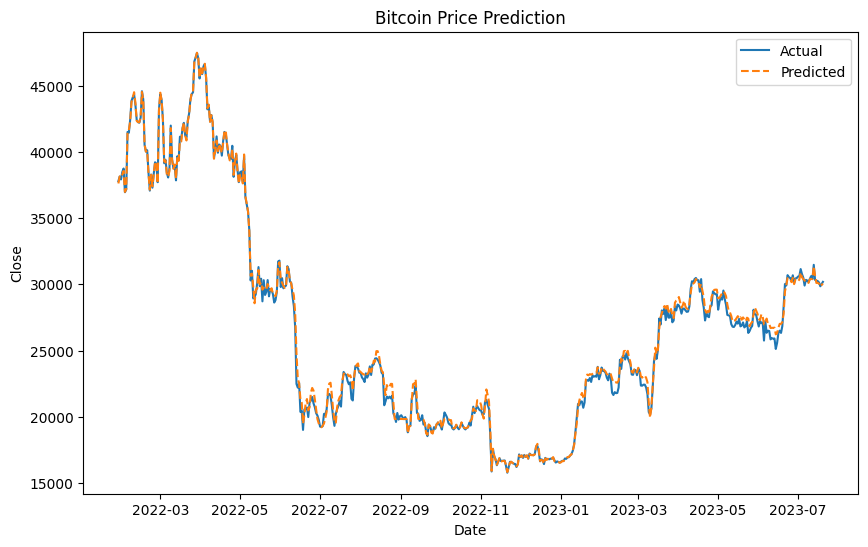

In [84]:
date_train, date_test = df.iloc[train_index]['Date'], df.iloc[test_index]['Date']

plt.figure(figsize=(10, 6))
plt.plot(date_test, y_test, label='Actual')
plt.plot(date_test, predictions, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()